In [1]:
from commonfunctions import *
from utility_functions import *
from skimage.filters import sobel_h, sobel_v, laplace
from skimage.io import imshow, imread
from skimage.filters import threshold_otsu, threshold_niblack, threshold_local, threshold_li, apply_hysteresis_threshold, try_all_threshold
from skimage.morphology import binary_erosion, binary_dilation, binary_opening, binary_closing, skeletonize, thin
from skimage.transform import hough_line, hough_line_peaks, hough_circle, hough_circle_peaks
from skimage.feature import canny, blob_dog, blob_log, blob_doh, corner_harris, corner_subpix, corner_peaks, match_template
from skimage import  color, data, transform, exposure
from skimage.draw import line,disk, circle_perimeter
from scipy.signal import convolve2d

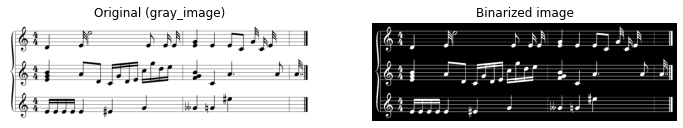

In [2]:
## NOTE you can find a list of musical symbols and their names here https://en.wikipedia.org/wiki/List_of_musical_symbols . 
# This facilitates naming variables and writing comments.
## NOTE We will do the same transformation functions rotate/scale/crop/... on both binary and gray images in parallel
## so that if anyone needed to work on the gray image at any time. it will be available

## Thresholding:
##---------------------------------

gray_image = rgb2gray(imread('test-set-scanned/test-cases/02.PNG'))  # 'test-set-scanned/test-cases/02.PNG'
binary_image = gray_image

# thresh = threshold_niblack(binary_image, 55, k=0.8)
# thresh = threshold_local(binary_image, block_size=205)  # block_size must be odd


# thresh = threshold_li(binary_image)       # Works well with camera captured images
thresh = threshold_otsu(binary_image)       # Works well with scanned image (High quality images)

binary_image= binary_image < thresh
show_images([gray_image, binary_image], ["Original (gray_image)", "Binarized image"])
# fig, ax = try_all_threshold(gray_image, figsize=(10, 6), verbose=False)

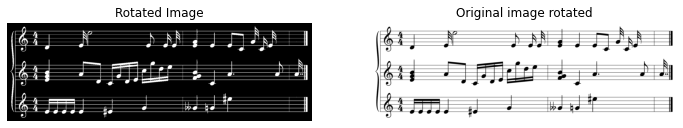

In [3]:
## Initial Orientation Adjustment:
##---------------------------------

#This cell and the next 3 cells were written by Ali & Saad
#And they are equivalent to:
rotated_image, rotation_angle = adjust_orientation(binary_image)
original_image_rotated = transform.rotate(gray_image, rotation_angle, resize=False, clip=False, cval=0, preserve_range=True)
# If orientation is incorrect (the image was rotated in the reverse direction) then rotate by 180
# This is know by checking the location of the "Brace". If it is on the left side then the orientation is correct.
# if it is on the right side then the orientation is incorrect.
if(not check_if_orientation_is_correct):
    rotated_image = transform.rotate(binary_image, 180, resize=False, clip=False, cval=0, preserve_range=True)
    original_image_rotated = transform.rotate(gray_image, 180, resize=False, clip=False, cval=0, preserve_range=True)
show_images([rotated_image, original_image_rotated], ["Rotated Image" , "Original image rotated"])
binary_image = rotated_image
gray_image = original_image_rotated

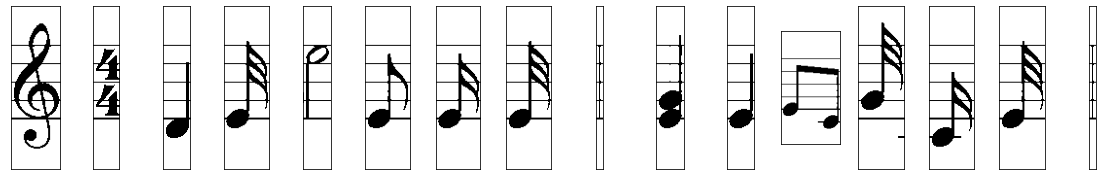

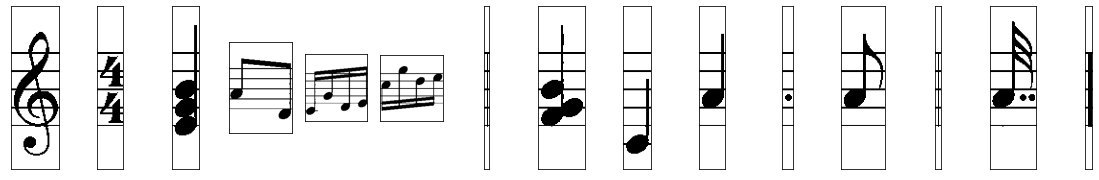

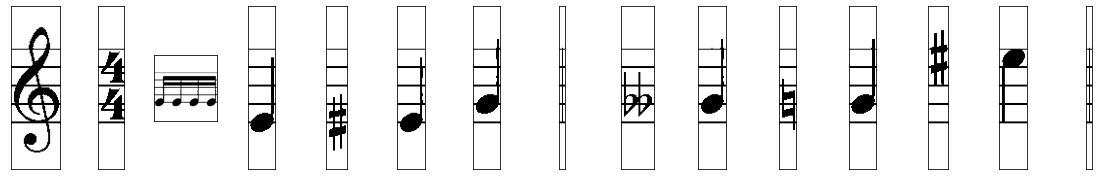

In [4]:
## Row segmentation
row_images, row_images_original = segment_image_into_rows(binary_image, gray_image)
# show_images([remove_staff_lines(row_images[0])])
## Then column segmentation
symbols = []
for i, row_img in enumerate(row_images):
    original_row = row_images_original[i]
    ## Adjust orientation again for each row
    row_img, rotation_angle = adjust_orientation(row_img)
    row_img = np.round(row_img).astype(int)

    original_row = transform.rotate(original_row, rotation_angle, resize=False, clip=False, cval=0)
    original_row= np.round(original_row).astype(int)

    symbols.append(segment_symbols(row_img, original_row))
    fig, axs = plt.subplots(1, len(symbols[i]), figsize=(20,3))
    for i, symbol in enumerate(symbols[i]):
        axs[i].imshow(symbol)
        axs[i].set_xticks([]) 
        axs[i].set_yticks([]) 
    plt.show()


In [6]:
## TODO Do classification on each symbol in symbols array
total_note = []
for row in symbols:
    row_notes = []
    for symbol in row:
        symbol_label = classify_symbol(symbol)
        symbol_position = calc_symbol_position(symbol)
        note = get_note(symbol_label, symbol_position)
        row_notes.append(note)
    total_note.append(row_notes)

## TODO Write extracted notes to a text file
